In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show, close
from scipy import optimize
import sympy as sp
from scipy.integrate import quad
from scipy.optimize import fsolve, approx_fprime

In [310]:
# Load in spreadsheet raw data
df_nolens1 = pd.read_csv("nolensledrun1.csv")
df_nolens2 = pd.read_csv("nolensledrun2.csv")
df_nolens3 = pd.read_csv("nolensledrun3.csv")

df_200lens1 = pd.read_csv("200lensledrun1.csv")
df_200lens2 = pd.read_csv("200lensledrun2.csv")
df_200lens3 = pd.read_csv("200lensledrun3.csv")

df_gravsmall1 = pd.read_csv("smallgravlensledrun1.csv")
df_gravsmall2 = pd.read_csv("smallgravlensledrun2.csv")
df_gravsmall3 = pd.read_csv("smallgravlensledrun3.csv")

df_gravbig1 = pd.read_csv("biggravlensledrun1_fixed.csv")  # This one is fixed because it had to be merged with trial 4
df_gravbig2 = pd.read_csv("biggravlensledrun2.csv")
df_gravbig3 = pd.read_csv("biggravlensledrun3.csv")
df_gravbig4 = pd.read_csv("biggravlensledrun5.csv") # Trial 4 is missing on purpose

df_distances = pd.read_csv("FinalDistances.csv")

FUNCTIONS FOR EXTRACTING DATA AND CALCULATING AVERAGES

In [311]:
def grab_data(df, start_intensity, end_intensity):
    '''Goes into the dataframe and grabs the data set that you want and returns an array for the times and the corresponding intensities'''
    data = df.loc[:, start_intensity : end_intensity]
    intensity_columns = [col for col in data.columns if "Light" in col]
    intensity = data[intensity_columns]
    return intensity.apply(pd.to_numeric, errors='coerce').dropna().values

def calc_avg_intensity(intensity):
    '''Calculates the average intensity of the measured light intensity over time and returns a list of the values for each position. assumes the input intensity to be in panda array format'''
    avg_intensity = [np.nanmean(intensity[:, i]) for i in range(intensity.shape[1])]
    return avg_intensity

def calibrate_distance(distances):
    distances = pd.to_numeric(distances, errors='coerce')
    calibrated_distances = [1875 - i for i in distances]
    return calibrated_distances

NOLENS!
Grabbing the data for the nolens case and calculating the average measured intensity for a distance. 

In [312]:
start_intensity_nolens = 'Light Intensity (lx) Run #1'
end_intensity_nolens = 'Light Intensity (lx) Run #13'

intensity_nolens1 = grab_data(df_nolens1, start_intensity_nolens, end_intensity_nolens)

intensity_nolens2 = grab_data(df_nolens2, start_intensity_nolens, end_intensity_nolens)

intensity_nolens3 = grab_data(df_nolens3, start_intensity_nolens, end_intensity_nolens)

intensities_nolens = np.vstack([intensity_nolens1, intensity_nolens2, intensity_nolens3])


distances_nolens_uncalibrated = df_distances['nolens'].dropna().tolist()
distances_nolens = np.array(calibrate_distance(distances_nolens_uncalibrated))


In [313]:
avg_intensity_nolens1 = calc_avg_intensity(intensity_nolens1)
avg_intensity_nolens2 = calc_avg_intensity(intensity_nolens2)
avg_intensity_nolens3 = calc_avg_intensity(intensity_nolens3)
avg_intensities_nolens = [np.array(avg_intensity_nolens1), np.array(avg_intensity_nolens2), np.array(avg_intensity_nolens3)]

avg_intensity_nolens= [(a + b + c) / 3 for a, b, c in zip(avg_intensity_nolens1, avg_intensity_nolens2, avg_intensity_nolens3)]


ERROR CALCULATION

In [314]:
def errors(avg_intensity_trials_list, intensities_bunch): # input list of arrays: [trial1_array, trial2_array, ...]

    N = len(avg_intensity_trials_list)
    if N == 3:
        t1,t2,t3 = avg_intensity_trials_list
        m = np.mean([t1,t2,t3], axis=0)
        x2_mean = np.mean([t1**2,t2**2,t3**2], axis=0)
        x_mean_2 = (np.mean([t1,t2,t3], axis=0))**2
        err_mean = np.sqrt((x2_mean - x_mean_2)/(N-1))


    elif N == 4:  # for those with 4 trials
        t1,t2,t3,t4 = avg_intensity_trials_list
        m = np.mean([t1,t2,t3,t4], axis=0)
        x2_mean = np.mean([t1**2,t2**2,t3**2,t4**2], axis=0)
        x_mean_2 = (np.mean([t1,t2,t3,t4], axis=0))**2
        err_mean = np.sqrt((x2_mean - x_mean_2)/N-1)

    
    deviations = []
    intensities_nested = intensities_bunch.T
    for i in range(len(intensities_nested)):
        maximum = np.max(intensities_nested[i])
        minimum = np.min(intensities_nested[i])
        deviation = (maximum - minimum) / 2
        deviations.append(deviation)

    largest_error = np.where(deviations > err_mean, deviations, err_mean)
    return largest_error

In [315]:
error_nolens = errors(avg_intensities_nolens, intensities_nolens)

PLOTTING AND FITTING

In [316]:
def fall_off(distances, multiple=1, y=0):
    distances = pd.to_numeric(distances, errors='coerce')
    function = (multiple * (1 / distances**2)) + y
    return function

def plot_intensity_vs_distance(distance, avg_intensity, intensity_error, fitted_params, title='Intensity of light at a given distance away', xlabel='Distance from source (mm)', ylabel='Intensity (Lx)', fit_label="Fitted Curve", data_label="Measured Data"):
    '''
    General function to plot light intensity vs distance with error bars and a fitted curve.
    '''
    multiple, offset = fitted_params

    fig = plt.figure(figsize=(8, 6))
    frame = fig.add_subplot(1, 1, 1)
    frame.errorbar(distance, avg_intensity, yerr=intensity_error, ecolor='red', fmt='.', label=data_label)
    fitted_curve = fall_off(distance, multiple, offset)
    frame.plot(distance, fitted_curve, label=fit_label)

    frame.set_xlabel(xlabel)
    frame.set_ylabel(ylabel)
    frame.legend()
    frame.grid()
    fig.suptitle(title)
    plt.show()
    plt.close(fig)

In [317]:
multiple_nolens = 180000
offset_nolens =  623

inguess_nolens = np.array([multiple_nolens, offset_nolens])

fit_nolens, cov_nolens = optimize.curve_fit(fall_off, distances_nolens, avg_intensity_nolens, p0=inguess_nolens, sigma=error_nolens, absolute_sigma=True)
fitted_multiple_nolens, fitted_offset_nolens = fit_nolens
error_parameters_nolens = np.sqrt(np.diagonal(cov_nolens))
title_nolens = 'Intensity for of white light at a given distance away from light source'

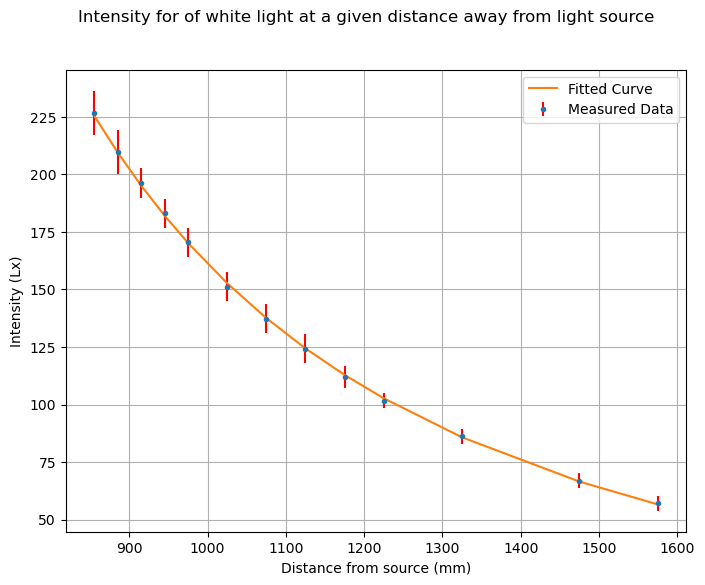

[(175125049.57967696, 5005814.599550284), (-13.992439485362244, 3.651672550139553)]


In [318]:
plot_intensity_vs_distance(distances_nolens, avg_intensity_nolens, error_nolens, fit_nolens, title=title_nolens)

parameters_nolens = zip(fit_nolens, error_parameters_nolens)
print([(a, b) for a, b in parameters_nolens])

In [319]:
def error_in_averages(avg1, avg2, avg3):
    error_avg_nolens = []
    for a,b,c in zip(avg1, avg2, avg3):
        m = (a+b+c)/3
        err_in_mean = np.sqrt(((a-m)**2 + (b-m)**2 + (c-m)**2)/3)
    
        error_avg_nolens.append(err_in_mean)
    return error_avg_nolens

error_avg_nolens1 = error_in_averages(avg_intensity_nolens1, avg_intensity_nolens2, avg_intensity_nolens3)

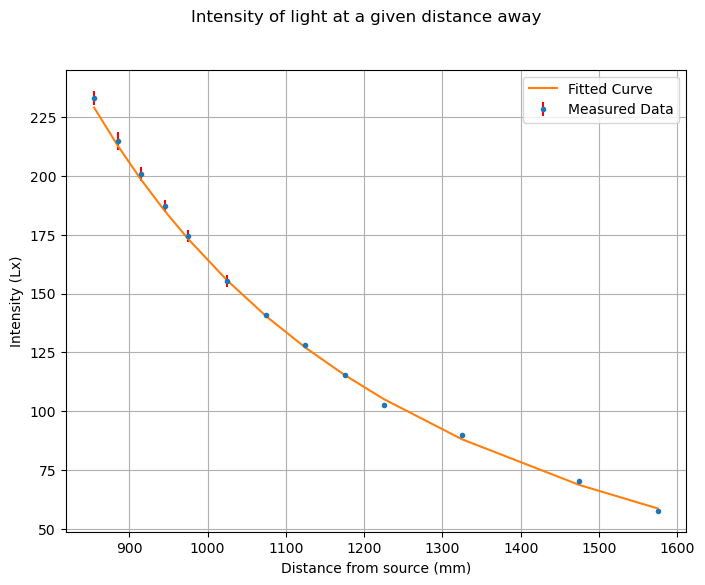

In [320]:
error_nolens1 = []
for i in range(intensity_nolens1.shape[1]):
    column = intensity_nolens1[:, i]
    standard_deviation = np.std(column, ddof=1)
    error_nolens1.append(standard_deviation)

error_nolens1 = np.array(error_nolens1)
condition = error_nolens1 > 0
error_nolens11 = np.where(condition, error_nolens1, np.min(error_nolens1[ error_nolens1 != 0]))

multiple_nolens = 150000000
offset_nolens =  50
inguess_nolens1 = np.array([multiple_nolens, offset_nolens])

fit_nolens1, cov_nolens1 = optimize.curve_fit(fall_off, distances_nolens, avg_intensity_nolens1, p0=inguess_nolens1, sigma=error_nolens11, absolute_sigma=True)

plot_intensity_vs_distance(distances_nolens, avg_intensity_nolens1, error_nolens1, fit_nolens1)

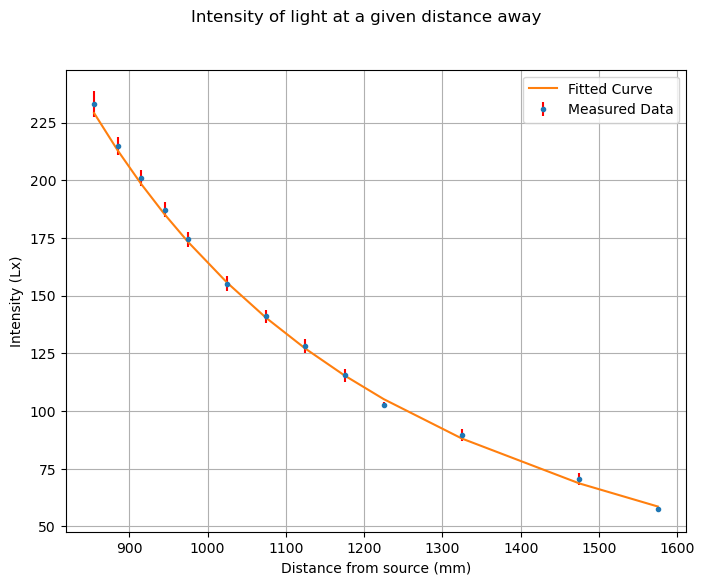

In [321]:
fit_nolens1, cov_nolens1 = optimize.curve_fit(fall_off, distances_nolens, avg_intensity_nolens1, p0=inguess_nolens1, sigma=error_nolens11, absolute_sigma=True)

plot_intensity_vs_distance(distances_nolens, avg_intensity_nolens1, error_avg_nolens1, fit_nolens1)

200LENS!


In [322]:
start_intensity_200lens = 'Light Intensity (lx) Run #1'
end_intensity_200lens = 'Light Intensity (lx) Run #23'

intensity_200lens1 = grab_data(df_200lens1, start_intensity_200lens, end_intensity_200lens)

intensity_200lens2 = grab_data(df_200lens2, start_intensity_200lens, end_intensity_200lens)

intensity_200lens3 = grab_data(df_200lens3, start_intensity_200lens, end_intensity_200lens)

intensities_200lens = np.vstack([intensity_200lens1, intensity_200lens2, intensity_200lens3])

distances_200lens_uncalibrated = df_distances['200lens'].dropna().tolist()
distances_200lens = np.array(calibrate_distance(distances_200lens_uncalibrated))


In [323]:
avg_intensity_200lens1 = calc_avg_intensity(intensity_200lens1)
avg_intensity_200lens2 = calc_avg_intensity(intensity_200lens2)
avg_intensity_200lens3 = calc_avg_intensity(intensity_200lens3)
avg_intensities_200lens = [np.array(avg_intensity_200lens1), np.array(avg_intensity_200lens2), np.array(avg_intensity_200lens3)]

avg_intensity_200lens= [(a + b + c) / 3 for a, b, c in zip(avg_intensity_200lens1, avg_intensity_200lens2, avg_intensity_200lens3)]

error_200lens = errors(avg_intensities_200lens, intensities_200lens)
error_200lens[-1] = 0.1

In [324]:


# def peaked_fall_off(distances, multiple, offset, width, I_max, peak):
#     fall_off = (multiple * (1 / distances**2)) + offset
#     gaussian = I_max * np.exp((-(distances-peak)**2)/(2*(width**2))) + offset
#     return fall_off + gaussian

def peaked_fall_off(distances, multiple, offset, I_max, width, peak):
    fall_off = (multiple * (1 / distances**2))
    cauchy = I_max / (np.pi * width * (1 + ((distances - peak) / width)**2)) + offset
    return fall_off + cauchy


def peaked_fall_off_gaussian(distances, multiple, offset, width, I_max, peak):
    fall_off = (multiple * (1 / distances**2)) + offset
    gaussian = I_max * np.exp((-(distances-peak)**2)/(2*width**2)) + offset
    return fall_off + gaussian


def cauchy_distribution(distances, multiple, offset, width, I_max, peak):
    cauchy = 1 / (np.pi * width * (1 + ((distances - peak) / width)**2)) + offset
    return cauchy

def plot_intensity_vs_distance_200mm(distances, avg_intensity, intensity_error, lens_location, fitted_params, title='Intensity of light at a given distance away', xlabel='Distance from source (mm)', ylabel='Intensity (Lx)', fit_label="Fitted Curve", data_label="Measured Data"):
    '''
    General function to plot light intensity vs distance with error bars and a fitted curve.
    '''
    multiple, offset, I_max, width, peak = fitted_params

    fig = plt.figure(figsize=(8, 6))
    frame = fig.add_subplot(1, 1, 1)
    frame.errorbar(distances, avg_intensity, yerr=intensity_error, ecolor='red', fmt='.', label=data_label)
    fitted_curve = peaked_fall_off(distances, multiple, offset, I_max, width, peak)
    frame.plot(distances, fitted_curve, label=fit_label)

    frame.set_xlabel(xlabel)
    frame.set_ylabel(ylabel)
    frame.axvline(lens_location, color='black', label="Convex Lens")
    #frame.axvline(location_focalpoint, color='violet', label="Focal Point")
    #frame.axvline(location_image, color='green', label="Image")
    frame.legend()
    frame.grid()
    fig.suptitle(title)
    plt.show()
    plt.close(fig)

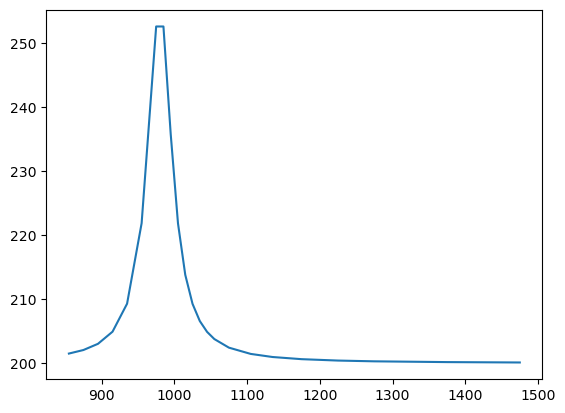

In [325]:
multiple_200lens = 100000
offset_200lens = 200
I_max_200lens = 3500
width_200lens = 20
peak_200lens = 980

inguess_200lens = np.array([multiple_200lens, offset_200lens, I_max_200lens, width_200lens, peak_200lens])

plt.plot(distances_200lens, peaked_fall_off(distances_200lens, multiple_200lens, offset_200lens, I_max_200lens, width_200lens,  peak_200lens))



In [326]:
fit_200lens, cov_200lens = optimize.curve_fit(peaked_fall_off, distances_200lens, avg_intensity_200lens, p0=inguess_200lens, sigma=error_200lens, absolute_sigma=True)
#fitted_multiple_200lens, fitted_offset_200lens = fit_200lens
error_parameters = np.sqrt(np.diagonal(cov_200lens))

parameters200lens = zip(fit_200lens, error_parameters)
print(parameters200lens)

print([(a, b) for a, b in parameters200lens])


[(15259452.795881921, 12441491.809771402), (-12.328786832754204, 5.041730241011497), (576057.2836631382, 5810.5056959701615), (47.76291530280635, 0.7241259848441579), (993.0756365698504, 0.3783997662092298)]


In [327]:
%%sql


UsageError: Cell magic `%%sql` not found.


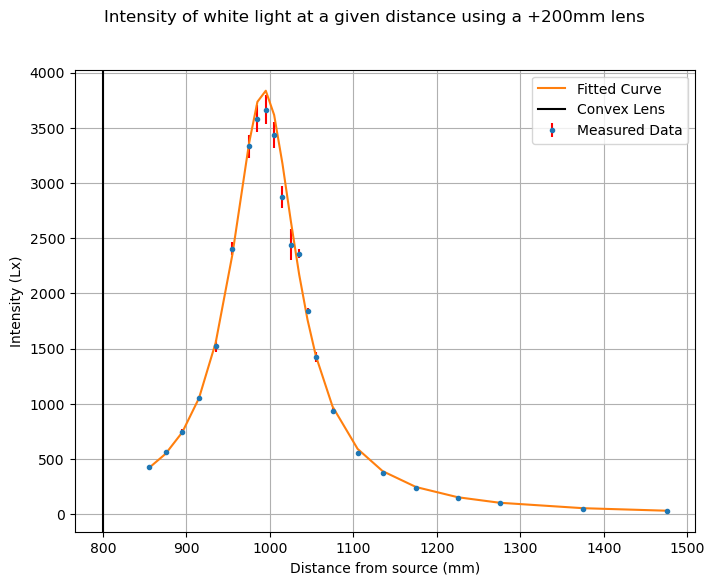

In [328]:
location_200lens = 1875 - 1075
title_200lens='Intensity of white light at a given distance using a +200mm lens'
plot_intensity_vs_distance_200mm(distances_200lens, avg_intensity_200lens, error_200lens, location_200lens, fit_200lens, title_200lens)



In [329]:
# SMALL GRAV LENS

In [330]:
start_intensity_gravsmall = 'Light Intensity (lx) Run #1'
end_intensity_gravsmall = 'Light Intensity (lx) Run #25'

intensity_gravsmall1 = grab_data(df_gravsmall1, start_intensity_gravsmall, end_intensity_gravsmall)
intensity_gravsmall2 = grab_data(df_gravsmall2, start_intensity_gravsmall, end_intensity_gravsmall)
intensity_gravsmall3 = grab_data(df_gravsmall3, start_intensity_gravsmall, end_intensity_gravsmall)

intensities_gravsmall = np.vstack([intensity_gravsmall1, intensity_gravsmall2, intensity_gravsmall3])

distances_gravsmall_uncalibrated = df_distances['smallgravlens'].dropna().tolist()
distances_gravsmall = np.array(calibrate_distance(distances_gravsmall_uncalibrated))


In [331]:
avg_intensity_gravsmall1 = calc_avg_intensity(intensity_gravsmall1)
avg_intensity_gravsmall2 = calc_avg_intensity(intensity_gravsmall2)
avg_intensity_gravsmall3 = calc_avg_intensity(intensity_gravsmall3)
avg_intensities_gravsmall = [np.array(avg_intensity_gravsmall1), np.array(avg_intensity_gravsmall2), np.array(avg_intensity_gravsmall3)]

avg_intensity_gravsmall= [(a + b + c) / 3 for a, b, c in zip(avg_intensity_gravsmall1, avg_intensity_gravsmall2, avg_intensity_gravsmall3)]

errors_gravsmall = errors(avg_intensities_gravsmall, intensities_gravsmall)

In [332]:
def peaked_fall_off_gaussian(distances, offset, width, I_max, peak):
    gaussian = I_max * np.exp((-(distances-peak)**2)/(2*width**2))
    return gaussian + offset

def skewed_peaked_fall_off_gaussian(distances, offset, width, I_max, peak, skew):
    # Skew factor: stretches the Gaussian asymmetrically
    skew_factor = 1 + skew * (distances - peak)
    skew_factor = np.clip(skew_factor, 0.1, None)  # Ensure no division by zero or negative values
    
    # Gaussian distribution with skew
    gaussian = I_max * np.exp(-(distances - peak)**2 / (2 * (width * skew_factor)**2))
    return gaussian + offset

# Define the Gaussian function compatible with Sympy
def peaked_gaussian(distances, offset, width, I_max, peak):
    gaussian = I_max * sp.exp(-((distances - peak)**2) / (2 * width**2))  # Gaussian term
    return gaussian + offset


In [333]:
# initial guess parameters
offset_gravsmall = 200
width_gravsmall1 = 100
peak_gravsmall = 900
I_max_gravsmall = 1200
skew = -1
inguess_gravsmall = np.array([offset_gravsmall, width_gravsmall1, I_max_gravsmall, peak_gravsmall, skew])

# fit optimization
fit_gravsmall, cov_gravsmall = optimize.curve_fit(skewed_peaked_fall_off_gaussian, distances_gravsmall, avg_intensity_gravsmall, p0=inguess_gravsmall, sigma=errors_gravsmall, absolute_sigma=True, method='trf')
fit_offset_gravsmall, fit_width_gravsmall1, fit_I_max_gravsmall, fit_peak_gravsmall, fit_skew = fit_gravsmall

# get errors
err_gravsmall = np.sqrt(np.diag(cov_gravsmall))
err_offset_gravsmall, err_width_gravsmall1, err_I_max_gravsmall, err_peak_gravsmall, err_skew = err_gravsmall


In [334]:
# Define the skewed Gaussian function
def skewed_peaked_gaussian(x, width, I_max, peak, skew):
    skew_factor = 1 + skew * (x - peak)
    skew_factor = np.clip(skew_factor, 0.1, None)  # Prevent division by zero or negative values
    gaussian = I_max * np.exp(-(x - peak) ** 2 / (2 * (width * skew_factor) ** 2))
    return gaussian

# Function to calculate bounds (c and d) where the area between them equals 32% of the total area
def area_bounds_func(bounds, func, peak, width, I_max, skew, area_total):
    c, d = bounds  # Bounds to solve for
    # Calculate area between c and d
    area, _ = quad(func, c, d, args=(width, I_max, peak, skew))
    # Two conditions: the area equals 32% of the total and the bounds are correctly spaced
    return [
        area - 0.32 * area_total,  # 32% of total area condition
        d - c - width             # Ensures d and c are reasonably spaced
    ]

# Parameters (replace with actual values from fitting process)
width = fit_width_gravsmall1
I_max = fit_I_max_gravsmall
peak = fit_peak_gravsmall
skew = fit_skew
left_bound = -10000 + peak
right_bound =  1900

# Calculate the total area of the function
func = lambda x, *args: skewed_peaked_gaussian(x, *args)
area_total,_ = quad(skewed_peaked_gaussian, left_bound, right_bound, args=(width, I_max, peak, skew))

# Initial guesses for c and d
c_initial = 850  # Initial guess for left bound
d_initial = 1000  # Initial guess for right bound

# Solve for c and d using fsolve
bounds_solution = fsolve(area_bounds_func, [c_initial, d_initial], args=(func, peak, width, I_max, skew, area_total))

# Extract solutions
solution_c, solution_d = bounds_solution

# Print results
print(f"Total Area: {area_total}")
print(f"Left Bound (c): {solution_c}")
print(f"Right Bound (d): {solution_d}")


Total Area: 498374.3457585793
Left Bound (c): 867.7155719527417
Right Bound (d): 992.1658871407922


C:\Users\taisl\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [335]:
# Define the skewed Gaussian function
def skewed_peaked_gaussian(x, width, I_max, peak, skew):
    skew_factor = 1 + skew * (x - peak)
    skew_factor = np.clip(skew_factor, 0.1, None)  # Prevent division by zero or negative values
    gaussian = I_max * np.exp(-(x - peak) ** 2 / (2 * (width * skew_factor) ** 2))
    return gaussian

# Function to calculate bounds (c and d) where the area between them equals 32% of the total area
def area_bounds_func(bounds, func, peak, width, I_max, skew, area_total):
    c, d = bounds  # Bounds to solve for
    # Calculate area between c and d
    area, _ = quad(func, c, d, args=(width, I_max, peak, skew))
    # Two conditions: the area equals 32% of the total and the bounds are correctly spaced
    return [
        area - 0.32 * area_total,  # 32% of total area condition
        d - c - width             # Ensures d and c are reasonably spaced
    ]

# Parameters (replace with actual values from fitting process)
width = fit_width_gravsmall1
I_max = fit_I_max_gravsmall
peak = fit_peak_gravsmall
skew = fit_skew
left_bound = -10000 + peak
right_bound =  1900

# Calculate the total area of the function
func = lambda x, *args: skewed_peaked_gaussian(x, *args)
area_total, area_total_error = quad(skewed_peaked_gaussian, left_bound, right_bound, args=(width, I_max, peak, skew))

# Initial guesses for c and d
c_initial = 850  # Initial guess for left bound
d_initial = 1000  # Initial guess for right bound

# Solve for c and d using fsolve
bounds_solution = fsolve(
    area_bounds_func, [c_initial, d_initial],
    args=(func, peak, width, I_max, skew, area_total)
)

# Extract solutions
solution_c, solution_d = bounds_solution

# Numerical differentiation to estimate errors
def residuals(bounds):
    return area_bounds_func(bounds, func, peak, width, I_max, skew, area_total)

# Estimate the Jacobian (partial derivatives)
jacobian = approx_fprime(bounds_solution, residuals, epsilon=1e-6)

# Calculate the covariance matrix from the Jacobian
cov_matrix = np.linalg.inv(jacobian.T @ jacobian)

# Extract standard errors (square root of diagonal elements of the covariance matrix)
error_c, error_d = np.sqrt(np.diag(cov_matrix))

# Combine area integration error into the uncertainty for c and d
integration_error_fraction = area_total_error / area_total
error_c = np.sqrt(error_c**2 + (integration_error_fraction * solution_c)**2)
error_d = np.sqrt(error_d**2 + (integration_error_fraction * solution_d)**2)

# Print results
print(f"Total Area: {area_total} ± {area_total_error}")
print(f"Left Bound (c): {solution_c} ± {error_c}")
print(f"Right Bound (d): {solution_d} ± {error_d}")


Total Area: 498374.3457585793 ± 0.0026793647176432955
Left Bound (c): 867.7155719527417 ± 13.64810342144485
Right Bound (d): 992.1658871407922 ± 12.6481039092763


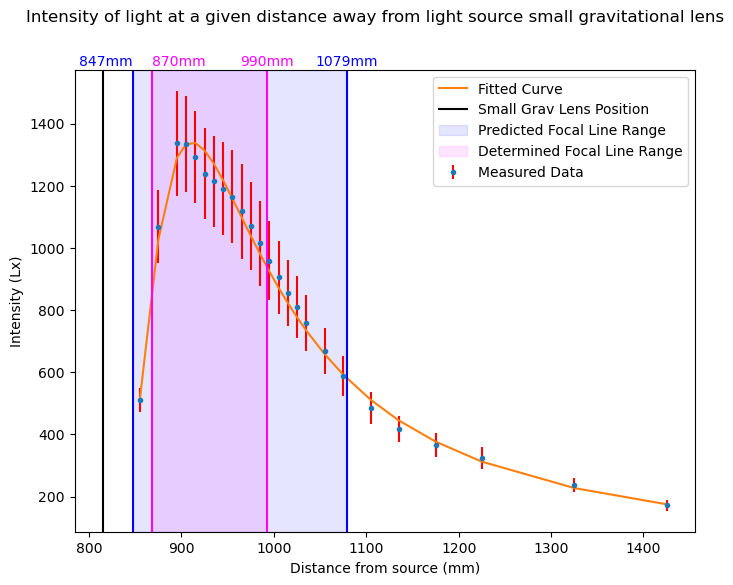

Best Fit Values Are: offset:-103.57, width:66.58, Imax:1444.00, peak location:910.97, skew:0.0063
Corresponding errors offset:180.44, width:5.28, Imax:192.68, peak location:6.19, skew:0.0011


In [336]:
title_gravsmall = 'Intensity of light for a given distance away from light source gravsmall'
# Locations of lens
location_smallgrav = 815
location_startfline = 847
location_endfline = 1079


fig = plt.figure(figsize=(8, 6))
frame = fig.add_subplot(1, 1, 1)
frame.errorbar(distances_gravsmall, avg_intensity_gravsmall, yerr=errors_gravsmall, ecolor='red', fmt='.', label="Measured Data")
fitted_curve = skewed_peaked_fall_off_gaussian(distances_gravsmall, fit_offset_gravsmall, fit_width_gravsmall1, fit_I_max_gravsmall, fit_peak_gravsmall, fit_skew)
estimate_curve = skewed_peaked_fall_off_gaussian(distances_gravsmall, offset_gravsmall, width_gravsmall1, I_max_gravsmall, peak_gravsmall, skew)
frame.plot(distances_gravsmall, fitted_curve, label="Fitted Curve")
#frame.plot(distances_gravsmall, estimate_curve, label="Estimate Curve")

frame.set_xlabel('Distance from source (mm)')
frame.set_ylabel('Intensity (Lx)')
frame.axvline(location_smallgrav, color='black', label="Small Grav Lens Position")
# Plot predicted focal line
frame.axvline(location_startfline, color='blue')
frame.axvline(location_endfline, color='blue')
frame.axvspan(location_startfline, location_endfline, color='blue', alpha=0.1, label="Predicted Focal Line Range")
frame.text(location_startfline, 1600, f'{location_startfline}mm', rotation=0, color='blue', ha='right', va='center')
frame.text(location_endfline, 1600, f'{location_endfline}mm', rotation=0, color='blue', ha='center', va='center')
# Plot real focal line
frame.axvspan(solution_c, solution_d, color = 'magenta', alpha=0.1, label="Determined Focal Line Range")
frame.axvline(solution_c, color = 'magenta')
frame.axvline(solution_d, color = 'magenta')
frame.text(solution_c, 1600, f'{int(round(solution_c, -1))}mm', rotation=0, color='magenta', ha='left', va='center')
frame.text(solution_d, 1600, f'{int(round(solution_d, -1))}mm', rotation=0, color='magenta', ha='center', va='center')


frame.legend()
fig.suptitle('Intensity of light at a given distance away from light source small gravitational lens')
plt.savefig("C:/Users/taisl/Desktop/graph-gravsmallv5.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f'Best Fit Values Are: offset:{fit_offset_gravsmall:.2f}, width:{fit_width_gravsmall1:.2f}, Imax:{fit_I_max_gravsmall:.2f}, peak location:{fit_peak_gravsmall:.2f}, skew:{fit_skew:.4f}')
print(f'Corresponding errors offset:{err_offset_gravsmall:.2f}, width:{err_width_gravsmall1:.2f}, Imax:{err_I_max_gravsmall:.2f}, peak location:{err_peak_gravsmall:.2f}, skew:{err_skew:.4f}')


In [337]:
# BIG GRAV LENS

In [338]:
start_intensity_gravbig = 'Light Intensity (lx) Run #1'
end_intensity_gravbig = 'Light Intensity (lx) Run #35'

intensity_gravbig1 = grab_data(df_gravbig1, start_intensity_gravbig, end_intensity_gravbig)
intensity_gravbig2 = grab_data(df_gravbig2, start_intensity_gravbig, end_intensity_gravbig)
intensity_gravbig3 = grab_data(df_gravbig3, start_intensity_gravbig, end_intensity_gravbig)
intensity_gravbig4 = grab_data(df_gravbig4, start_intensity_gravbig, end_intensity_gravbig)

distances_gravbig = np.array(calibrate_distance(df_distances['biggravlens'].dropna().tolist()))

intensities_gravbig = np.vstack([intensity_gravbig1, intensity_gravbig2, intensity_gravbig3, intensity_gravbig4])

avg_intensity_gravbig1 = calc_avg_intensity(intensity_gravbig1)
avg_intensity_gravbig2 = calc_avg_intensity(intensity_gravbig2)
avg_intensity_gravbig3 = calc_avg_intensity(intensity_gravbig3)
avg_intensity_gravbig4 = calc_avg_intensity(intensity_gravbig4)

avg_intensities_gravbig = [np.array(avg_intensity_gravbig1), np.array(avg_intensity_gravbig2), np.array(avg_intensity_gravbig3), np.array(avg_intensity_gravbig4)]

avg_intensity_gravbig= [(a + b + c + d) / 3 for a, b, c, d in zip(avg_intensity_gravbig1, avg_intensity_gravbig2, avg_intensity_gravbig3, avg_intensity_gravbig4)]

errors_gravbig = errors(avg_intensities_gravbig, intensities_gravbig)

In [339]:
offset_gravbig = -200
width_gravbig = 400
I_max_gravbig = 1000
peak_gravbig = 1300

# Locations of lens
location_gravbig = 820
location_startfline = 1077
location_endfline = 1422

# initial guess parameters
inguess_gravbig = np.array([offset_gravbig, width_gravbig, I_max_gravbig, peak_gravbig])

# fit optimization
fit_gravbig, cov_gravbig = optimize.curve_fit(peaked_fall_off_gaussian, distances_gravbig, avg_intensity_gravbig, p0=inguess_gravbig, sigma=errors_gravbig, absolute_sigma=True, method='trf')
fit_offset_gravbig, fit_width_gravbig, fit_I_max_gravbig, fit_peak_gravbig = fit_gravbig

# get errors
err_gravbig = np.sqrt(np.diag(cov_gravbig))
err_offset_gravbig, err_width_gravbig, err_I_max_gravbig, err_peak_gravbig = err_gravbig


In [341]:
# Set up initial values for bounds (replace with actual values from fitting process)
width = fit_width_gravbig
I_max = fit_I_max_gravbig
peak = fit_peak_gravbig

# Set large bounds (could not use infinity) centered around the peak
left_bound = -100000 + fit_peak_gravbig
right_bound = 100000 + fit_peak_gravbig

# Calculate total area
area_total, area_total_error = quad(peaked_fall_gaussian, left_bound, right_bound, args=(width, I_max, peak))

# Define Gaussian function
def peaked_fall_gaussian(distances, width, I_max, peak):
    return I_max * np.exp((-(distances - peak)**2) / (2 * width**2))

# Function to calculate bounds (a and b)
def area_bounds_func(bounds, func, peak, width, I_max, area_total):
    a,b = bounds  # Bounds to solve for
    # Calculate areas on left and right
    area_a, _ = quad(func, left_bound, a, args=(width, I_max, peak))
    area_b, _ = quad(func, b, right_bound, args=(width, I_max, peak))
    return [area_a - 0.16 * area_total,  area_b - 0.16 * area_total]


# Initial guesses
a_initial = 1170
b_initial = 1500

# Define the function to be integrated
func = lambda x, width, I_max, peak: peaked_fall_gaussian(x, width, I_max, peak)

# Solve for c and d using fsolve
bounds_solution = fsolve(area_bounds_func, [a_initial, b_initial], args=(func, peak, width, I_max, area_total))

# Extract solutions
solution_a, solution_b = bounds_solution

# Numerical differentiation to estimate errors
def residuals(bounds):
    return area_bounds_func(bounds, func, peak, width, I_max, area_total)

# Estimate the Jacobian (partial derivatives)
jacobian = approx_fprime(bounds_solution, residuals, epsilon=1e-6)

# Calculate the covariance matrix from the Jacobian
cov_matrix = np.linalg.inv(jacobian.T @ jacobian)

# Extract standard errors (square root of diagonal elements of the covariance matrix)
error_a, error_b = np.sqrt(np.diag(cov_matrix))

# Combine area integration error into the uncertainty for c and d
integration_error_fraction = area_total_error / area_total
error_a = np.sqrt(error_a**2 + (integration_error_fraction * solution_a)**2)
error_b = np.sqrt(error_b**2 + (integration_error_fraction * solution_b)**2)

# Print results
print(f"Total Area: {area_total} ± {area_total_error}")
print(f"Left Bound (a): {solution_a} ± {error_a}")
print(f"Right Bound (b): {solution_b} ± {error_b}")


212120.07622226188 0.00018174240086032967
Total Area: 212120.07622226188 ± 0.00018174240086032967
Left Bound (a): 1175.9934766566932 ± 0.0030386766302340513
Right Bound (b): 1487.915239792283 ± 0.0030386765962371566


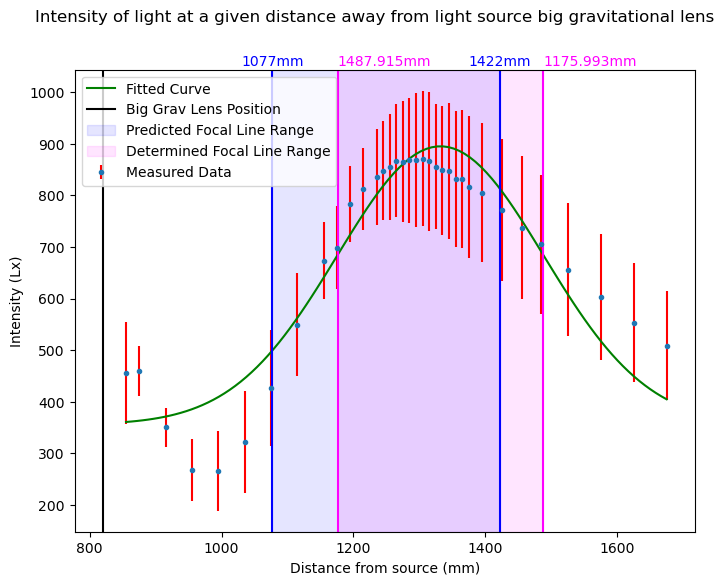

The best fitted param offset:355.66, width:156.83, I_max:539.59, peak location:1331.95
Corresponding errors offset:33.67, width:21.29, I_max:41.21, peak location:15.02


In [342]:
title_gravbig = 'Intensity of light for a given distance away from light source gravbig'

fig = plt.figure(figsize=(8, 6))
frame = fig.add_subplot(1, 1, 1)
frame.errorbar(distances_gravbig, avg_intensity_gravbig, yerr=errors_gravbig, ecolor='red', fmt='.', label="Measured Data")

distances_toplot_gravbig = np.linspace(distances_gravbig[0], distances_gravbig[-1], 100)

fitted_curve = peaked_fall_off_gaussian(distances_toplot_gravbig, fit_offset_gravbig, fit_width_gravbig, fit_I_max_gravbig, fit_peak_gravbig)
estimate_curve = peaked_fall_off_gaussian(distances_toplot_gravbig, offset_gravbig, width_gravbig, I_max_gravbig, peak_gravbig)
#frame.plot(distances_gravbig, estimate_curve, label="Estimated Curve")
frame.plot(distances_toplot_gravbig, fitted_curve, color='green',label="Fitted Curve")


frame.set_xlabel('Distance from source (mm)')
frame.set_ylabel('Intensity (Lx)')
frame.axvline(location_gravbig, color='black', label="Big Grav Lens Position")
# Plot predicted focal line
frame.axvline(location_startfline, color='blue')
frame.axvline(location_endfline, color='blue')
frame.axvspan(location_startfline, location_endfline, color='blue', alpha=0.1, label="Predicted Focal Line Range")
frame.text(location_startfline, 1060, f'{location_startfline}mm', rotation=0, color='blue', ha='center', va='center')
frame.text(location_endfline, 1060, f'{location_endfline}mm', rotation=0, color='blue', ha='center', va='center')
# Plot real focal line
frame.axvspan(solution_a, solution_b, color = 'magenta', alpha=0.1, label="Determined Focal Line Range")
frame.axvline(solution_a, color = 'magenta')
frame.axvline(solution_b, color = 'magenta')
frame.text(solution_a, 1060, '1487.915mm', rotation=0, color='magenta', ha='left', va='center')
frame.text(solution_b, 1060, '1175.993mm', rotation=0, color='magenta', ha='left', va='center')

frame.legend()
fig.suptitle('Intensity of light at a given distance away from light source big gravitational lens')
plt.savefig("C:/Users/taisl/Desktop/graph-gravbigv5.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f'The best fitted param offset:{fit_offset_gravbig:.2f}, width:{fit_width_gravbig:.2f}, I_max:{fit_I_max_gravbig:.2f}, peak location:{fit_peak_gravbig:.2f}')
print(f'Corresponding errors offset:{err_offset_gravbig:.2f}, width:{err_width_gravbig:.2f}, I_max:{err_I_max_gravbig:.2f}, peak location:{err_peak_gravbig:.2f}')
